In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

/home/hidehisa/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_dir = "/home/hidehisa/.kaggle/competitions/plasticc"
train = pd.read_csv(data_dir + "/train_with_cluster.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [3]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df[
        'flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (
        agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff"]]
    df2 = pd.merge(df, agg_df, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff
    del df2["flux"]
    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None,
        "cid_ce": [{"normalize": True}]
    }
    fcp2 = {
        "fft_coefficient": [{
            "coeff": 0,
            "attr": "abs"
        }, {
            "coeff": 1,
            "attr": "abs"
        }],
        "abs_energy": None,
        "sample_entropy": None
    }
    fcp_flux = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None,
        "mean_change": None,
        "mean_abs_change": None,
        "cid_ce": [{"normalize": True}]
    }
    fcp_flux_by_flux_ratio_sq = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=6)
    agg_df_ts2 = extract_features(
        df2,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="flux_norm",
        default_fc_parameters=fcp2,
        n_jobs=4
    )
    agg_df_flux = extract_features(
        df,
        column_id="object_id",
        column_value="flux",
        default_fc_parameters=fcp_flux,
        n_jobs=4
    )
    agg_df_ffrs = extract_features(
        df,
        column_id="object_id",
        column_value="flux_by_flux_ratio_sq",
        default_fc_parameters=fcp_flux_by_flux_ratio_sq,
        n_jobs=4
    )
    df_det = df[df['detected'] == 1].copy()

    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=8)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts2, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_flux, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ffrs, on="id")
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df


def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (
        new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({"normalized_mean": "std"})


def passband_std_difference(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(["object_id",
                              "passband"])["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()


def num_outliers(df):
    new_df = df.groupby("object_id").agg({"flux": ["mean", "std"]})
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = (
        (new_df["flux"] > new_df["upper_sigma"]) |
        (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = (
        (new_df["flux"] > new_df["upper_2sigma"]) |
        (new_df["flux"] < new_df["lower_2sigma"])).astype(int)

    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [4]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) from 
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine, 
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2)), 
   }


def process_meta(meta_df):
    meta_dict = dict()
    # distance
    meta_dict.update(haversine_plus(meta_df['ra'].values, meta_df['decl'].values, 
                   meta_df['gal_l'].values, meta_df['gal_b'].values))
    #
    meta_dict['hostgal_photoz_certain'] = np.multiply(
            meta_df['hostgal_photoz'].values, 
             np.exp(meta_df['hostgal_photoz_err'].values))
    
    meta_df = pd.concat([meta_df, pd.DataFrame(meta_dict, index=meta_df.index)], axis=1)
    return meta_df

In [5]:
def get_full(df, meta):
    agg_basic = basic(df)
    cl_mean_diff = cluster_mean_diff(df)
    ps_std_diff = passband_std_difference(df)
    num_out = num_outliers(df)

    full = pd.merge(agg_basic, cl_mean_diff, how="left", on="object_id")
    full = pd.merge(full, ps_std_diff, how="left", on="object_id")
    full = pd.merge(full, num_out, how="left", on="object_id")
    meta = process_meta(meta)
    full = pd.merge(full, meta, how="left", on="object_id")
    if "target" in full.columns:
        full.drop("target", axis=1, inplace=True)
    return full


def train_data(df, meta):
    full = get_full(df, meta)
    y = meta.target
    classes = sorted(y.unique())
    class_weight = {c: 1 for c in classes}

    for c in [64, 15]:
        class_weight[c] = 2
    oof_df = full[["object_id"]]
    del full['object_id'], full['distmod'], full['hostgal_specz']
    del full['ra'], full['decl'], full['gal_l'], full['gal_b'], full['ddf']
    return full, y, classes, class_weight, oof_df

In [6]:
%%time
full, y, classes, class_weight, oof_df = train_data(train, meta)

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 94.31it/s]


CPU times: user 21.1 s, sys: 1.28 s, total: 22.4 s
Wall time: 37.1 s


In [49]:
train_mean = full.mean(axis=0)
full.replace([np.inf, -np.inf], np.nan, inplace=True)
full.fillna(0, inplace=True)

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

In [9]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss


def multi_logloss_tf(y_true, y_pred):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    y_p = tf.clip_by_value(y_pred, 1e-15, 1-1e-15)
    y_p_log = tf.log(y_p)
    y_log_ones = tf.reduce_sum(y_true * y_p_log, axis=0)
    nb_pos = tf.reduce_sum(y_true, axis=0)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - tf.reduce_sum(y_w) / np.sum(class_arr)
    return loss

In [10]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [11]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [56]:
full_train_new = full.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

In [52]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [53]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [60]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    

Train on 6274 samples, validate on 1574 samples
Epoch 1/600
6274/6274 [==============================] - 1s 237us/step - loss: 2.5560 - mywloss: 2.5560 - val_loss: 1.4634 - val_mywloss: 1.4634
Epoch 2/600
6274/6274 [==============================] - 0s 65us/step - loss: 1.8947 - mywloss: 1.8947 - val_loss: 1.2534 - val_mywloss: 1.2534
Epoch 3/600
6274/6274 [==============================] - 0s 65us/step - loss: 1.6245 - mywloss: 1.6245 - val_loss: 1.1496 - val_mywloss: 1.1496
Epoch 4/600
6274/6274 [==============================] - 0s 66us/step - loss: 1.5152 - mywloss: 1.5152 - val_loss: 1.1361 - val_mywloss: 1.1361
Epoch 5/600
6274/6274 [==============================] - 0s 65us/step - loss: 1.4439 - mywloss: 1.4439 - val_loss: 1.0447 - val_mywloss: 1.0447
Epoch 6/600
6274/6274 [==============================] - 0s 69us/step - loss: 1.3406 - mywloss: 1.3406 - val_loss: 1.0138 - val_mywloss: 1.0138
Epoch 7/600
6274/6274 [==============================] - 0s 69us/step - loss: 1.2753 - 

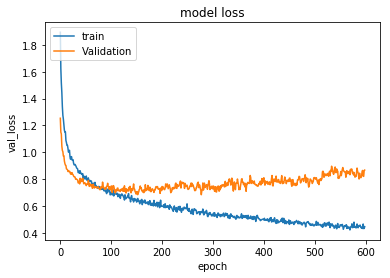

Loading Best Model
0.6713706710059744
Train on 6276 samples, validate on 1572 samples
Epoch 1/600
6276/6276 [==============================] - 1s 234us/step - loss: 2.4746 - mywloss: 2.4746 - val_loss: 1.3599 - val_mywloss: 1.3599
Epoch 2/600
6276/6276 [==============================] - 0s 64us/step - loss: 1.8401 - mywloss: 1.8401 - val_loss: 1.1936 - val_mywloss: 1.1936
Epoch 3/600
6276/6276 [==============================] - 0s 64us/step - loss: 1.6490 - mywloss: 1.6490 - val_loss: 1.1020 - val_mywloss: 1.1020
Epoch 4/600
6276/6276 [==============================] - 0s 64us/step - loss: 1.5143 - mywloss: 1.5143 - val_loss: 1.0778 - val_mywloss: 1.0778
Epoch 5/600
6276/6276 [==============================] - 0s 64us/step - loss: 1.4465 - mywloss: 1.4465 - val_loss: 1.0035 - val_mywloss: 1.0035
Epoch 6/600
6276/6276 [==============================] - 0s 64us/step - loss: 1.3478 - mywloss: 1.3478 - val_loss: 0.9878 - val_mywloss: 0.9878
Epoch 7/600
6276/6276 [==========================

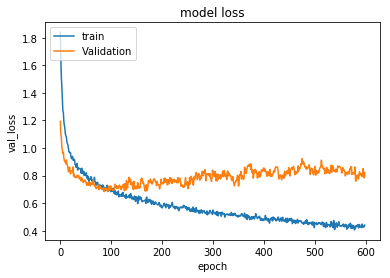

Loading Best Model
0.6945516055203915
Train on 6277 samples, validate on 1571 samples
Epoch 1/600
6277/6277 [==============================] - 2s 245us/step - loss: 2.5551 - mywloss: 2.5551 - val_loss: 1.4214 - val_mywloss: 1.4214
Epoch 2/600
6277/6277 [==============================] - 0s 65us/step - loss: 1.9372 - mywloss: 1.9372 - val_loss: 1.2304 - val_mywloss: 1.2304
Epoch 3/600
6277/6277 [==============================] - 0s 65us/step - loss: 1.6488 - mywloss: 1.6488 - val_loss: 1.1531 - val_mywloss: 1.1531
Epoch 4/600
6277/6277 [==============================] - 0s 65us/step - loss: 1.5321 - mywloss: 1.5321 - val_loss: 1.0877 - val_mywloss: 1.0877
Epoch 5/600
6277/6277 [==============================] - 0s 65us/step - loss: 1.4424 - mywloss: 1.4424 - val_loss: 1.0284 - val_mywloss: 1.0284
Epoch 6/600
6277/6277 [==============================] - 0s 65us/step - loss: 1.3580 - mywloss: 1.3580 - val_loss: 1.0173 - val_mywloss: 1.0173
Epoch 7/600
6277/6277 [==========================

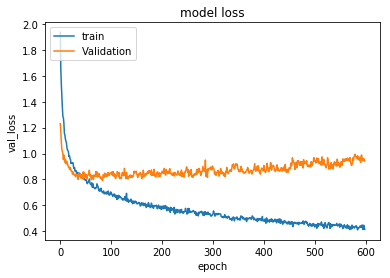

Loading Best Model
0.7712385277179443
Train on 6281 samples, validate on 1567 samples
Epoch 1/600
6281/6281 [==============================] - 2s 258us/step - loss: 2.5296 - mywloss: 2.5296 - val_loss: 1.4091 - val_mywloss: 1.4091
Epoch 2/600
6281/6281 [==============================] - 0s 65us/step - loss: 1.9035 - mywloss: 1.9035 - val_loss: 1.2450 - val_mywloss: 1.2450
Epoch 3/600
6281/6281 [==============================] - 0s 65us/step - loss: 1.6887 - mywloss: 1.6887 - val_loss: 1.1231 - val_mywloss: 1.1231
Epoch 4/600
6281/6281 [==============================] - 0s 65us/step - loss: 1.5318 - mywloss: 1.5318 - val_loss: 1.0368 - val_mywloss: 1.0368
Epoch 5/600
6281/6281 [==============================] - 0s 65us/step - loss: 1.4189 - mywloss: 1.4189 - val_loss: 1.0377 - val_mywloss: 1.0377
Epoch 6/600
6281/6281 [==============================] - 0s 65us/step - loss: 1.3835 - mywloss: 1.3835 - val_loss: 0.9594 - val_mywloss: 0.9594
Epoch 7/600
6281/6281 [==========================

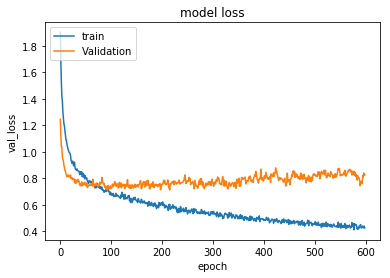

Loading Best Model
0.7272001779415216
Train on 6284 samples, validate on 1564 samples
Epoch 1/600
6284/6284 [==============================] - 2s 270us/step - loss: 2.5007 - mywloss: 2.5007 - val_loss: 1.5454 - val_mywloss: 1.5454
Epoch 2/600
6284/6284 [==============================] - 0s 66us/step - loss: 1.9166 - mywloss: 1.9166 - val_loss: 1.3607 - val_mywloss: 1.3607
Epoch 3/600
6284/6284 [==============================] - 0s 66us/step - loss: 1.6559 - mywloss: 1.6559 - val_loss: 1.2670 - val_mywloss: 1.2670
Epoch 4/600
6284/6284 [==============================] - 0s 66us/step - loss: 1.5020 - mywloss: 1.5020 - val_loss: 1.1743 - val_mywloss: 1.1743
Epoch 5/600
6284/6284 [==============================] - 0s 66us/step - loss: 1.4467 - mywloss: 1.4467 - val_loss: 1.1430 - val_mywloss: 1.1430
Epoch 6/600
6284/6284 [==============================] - 0s 66us/step - loss: 1.3773 - mywloss: 1.3773 - val_loss: 1.1016 - val_mywloss: 1.1016
Epoch 7/600
6284/6284 [==========================

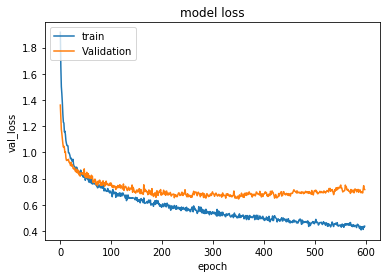

Loading Best Model
0.6272995203545279
MULTI WEIGHTED LOG LOSS : 0.69846 


In [61]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=[mywloss])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=1,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probaScalerbilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [46]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds, path):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    sample_sub = pd.read_csv(path)
    class_names = list(sample_sub.columns[1:-1])
    del sample_sub

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig("confusion_matrix.png")

In [47]:
save_cm(y, oof_preds, data_dir + "/sample_submission.csv")

Normalized confusion matrix
